In [ ]:
# In this code, we show how the accuracy drops for the various dataset with their model,
# In the case of dropping top k features suggested by LIME, SHAP, d_1 and DiCE.
# We do that for all the four datasets

In [ ]:
!pip install dice-ml # because we load adult from the helper

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RandomForestClassifier, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Diabetes Dataset
path = '/content/drive/MyDrive/BSC/Ideas_on_counterfactuals/Datasets/diabetes.csv'
df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# We now extract the mean values for each column
mean_values = df.mean()

In [ ]:
target = 'Outcome'
x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression()
model.fit(x_train_scaled, y_train)


LogisticRegression()

Comprehensiveness for d_1: -0.1750
Comprehensiveness for DiCE: 0.6985
Comprehensiveness for SHAP: -0.0044
Comprehensiveness for LIME: 0.5848


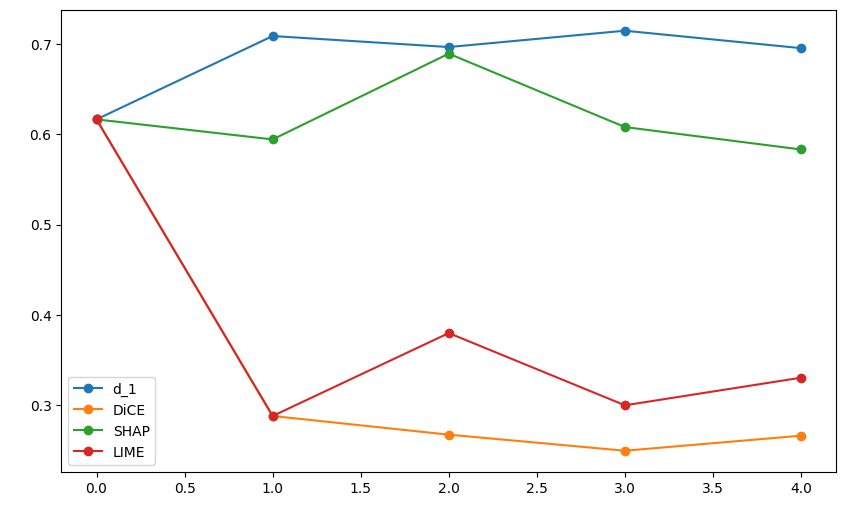

In [ ]:
# Ranks according to our explainers
rank_d1 = [5, 2, 3, 4]
rank_dice = [1, 7, 4, 3]
rank_shap = [4, 5, 0, 7]
rank_lime = [1, 5, 0, 6]


def mask_features(x, ranks, num_features):
    x_masked = x.copy()
    for i in range(num_features):
        x_masked[0, ranks[i]] = 0
    return x_masked


def calculate_comprehensiveness(model, x, ranks):
    original_proba = model.predict_proba(x)[0, 1] # 1 is the predicted class for this instance
    total_difference = 0
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x, ranks, l)
        masked_proba = model.predict_proba(x_masked)[0, 1]
        total_difference += (original_proba - masked_proba)
    return total_difference / (len(x_masked) + 1)

methods = {
    "d_1": rank_d1,
    "DiCE": rank_dice,
    "SHAP": rank_shap,
    "LIME": rank_lime
}

x_instance = x_test_scaled[0:1]  # the instance we want to explain
proba_results = {}
comprehensiveness_values = {}

for method, ranks in methods.items():
    proba_results[method] = []
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x_instance, ranks, l)
        proba = model.predict_proba(x_masked)[0, 1]
        proba_results[method].append(proba)

    comprehensiveness = calculate_comprehensiveness(model, x_instance, ranks)
    print(f"Comprehensiveness for {method}: {comprehensiveness:.4f}")
    comprehensiveness_values[method] = comprehensiveness


plt.figure(figsize=(10, 6))

for method, probas in proba_results.items():
    plt.plot(range(len(probas)), probas, label=f"{method}", marker='o')

plt.xlabel(" ")
plt.ylabel(" ")
plt.legend()
plt.grid(False)
plt.show()


### Heart disease dataset

In [ ]:
path = '/content/drive/MyDrive/BSC/Ideas_on_counterfactuals/Datasets/heart.csv'
df = pd.read_csv(path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
target = 'target'
x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = RandomForestClassifier()
model.fit(x_train_scaled, y_train)


RandomForestClassifier()

In [ ]:
model.predict_proba(x_test_scaled[0:1]) # so we have to extract class 0

array([[0.98, 0.02]])

Comprehensiveness for d_1: 0.3950
Comprehensiveness for DiCE: 0.4900
Comprehensiveness for SHAP: 0.2300
Comprehensiveness for LIME: 0.3500


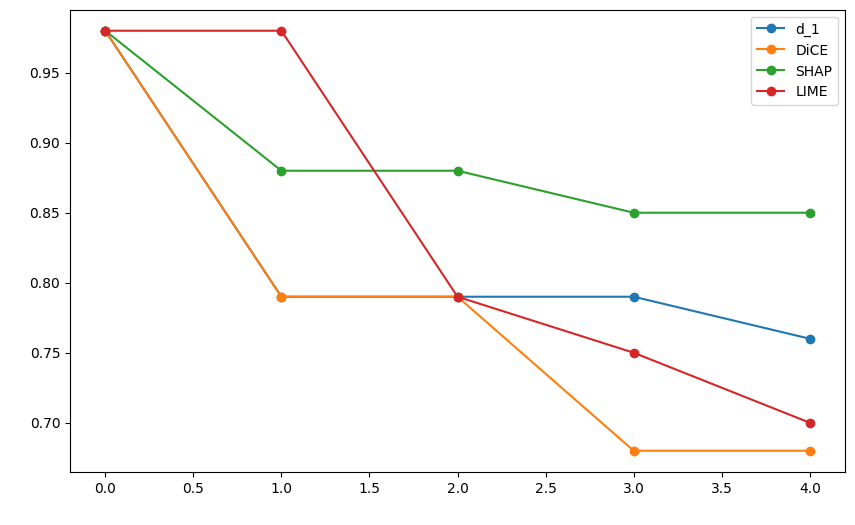

In [ ]:
rank_d1 = [2,1,12,8]
rank_dice = [2,1,7,12]
rank_shap = [7,3,0,4]
rank_lime = [1,2,9,8]


def mask_features(x, ranks, num_features):
    x_masked = x.copy()
    for i in range(num_features):
        x_masked[0, ranks[i]] = 0
    return x_masked


def calculate_comprehensiveness(model, x, ranks):
    original_proba = model.predict_proba(x)[0, 0] # 0 is the predicted class for this instance
    total_difference = 0
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x, ranks, l)
        masked_proba = model.predict_proba(x_masked)[0, 0]
        total_difference += (original_proba - masked_proba)
    return total_difference / (len(x_masked) + 1)

methods = {
    "d_1": rank_d1,
    "DiCE": rank_dice,
    "SHAP": rank_shap,
    "LIME": rank_lime
}

x_instance = x_test_scaled[0:1]  # the instance we want to explain
proba_results = {}
comprehensiveness_values = {}

for method, ranks in methods.items():
    proba_results[method] = []
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x_instance, ranks, l)
        proba = model.predict_proba(x_masked)[0, 0]
        proba_results[method].append(proba)

    comprehensiveness = calculate_comprehensiveness(model, x_instance, ranks)
    print(f"Comprehensiveness for {method}: {comprehensiveness:.4f}")
    comprehensiveness_values[method] = comprehensiveness


plt.figure(figsize=(10, 6))

for method, probas in proba_results.items():
    plt.plot(range(len(probas)), probas, label=f"{method}", marker='o')

plt.xlabel(" ")
plt.ylabel(" ")
plt.legend()
plt.grid(False)
plt.show()


### Student Depression Dataset

In [ ]:
path = '/content/drive/MyDrive/BSC/Ideas_on_counterfactuals/Datasets/Student Depression Dataset.csv'
df = pd.read_csv(path)
df.head()
df.drop(columns= 'id', axis=0, inplace=True)
df = df.dropna(how="any", axis=0)

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('Depression')

categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

target = 'Depression'
x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Separate categorical and numerical so we access indexes better

numerical_data_train = x_train[numerical_features]
categorical_data_train = x_train[categorical_features]
numerical_data_test = x_test[numerical_features]
categorical_data_test = x_test[categorical_features]

scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[numerical_features])
x_test_num = scaler.transform(x_test[numerical_features])

# Onehot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
x_train_cat = encoder.fit_transform(x_train[categorical_features]).todense()
x_test_cat = encoder.transform(x_test[categorical_features]).todense()

# Final concatenation
x_train_final = np.hstack((x_train_num, np.asarray(x_train_cat)))
x_test_final = np.hstack((x_test_num, np.asarray(x_test_cat)))

model = LogisticRegression()
model.fit(x_train_final, y_train)


LogisticRegression()

In [ ]:
model.predict_proba(x_test_final[0:1]) # class 1

array([[0.0543436, 0.9456564]])

Comprehensiveness for d_1: 0.0490
Comprehensiveness for DiCE: 0.1328
Comprehensiveness for SHAP: 0.0600
Comprehensiveness for LIME: -0.0093


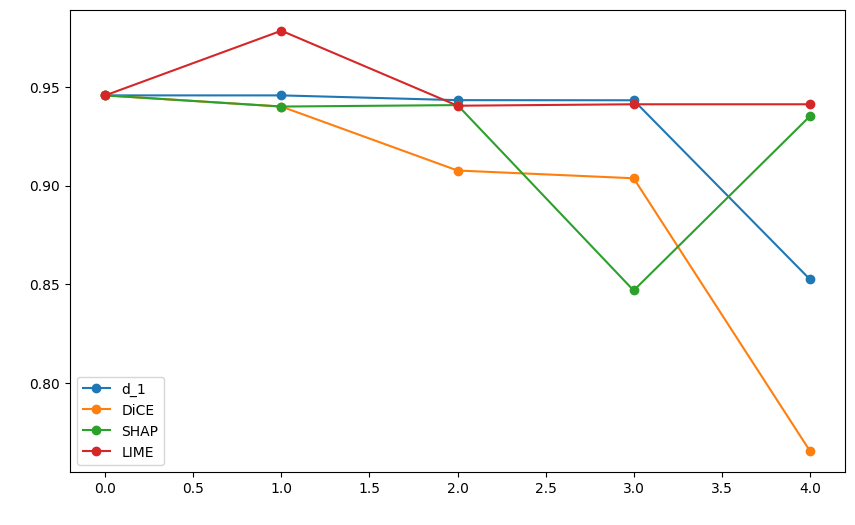

In [ ]:
rank_d1 = [5,3,2,7]
rank_dice = [0,6,3,7]
rank_shap = [0,4,7,1]
rank_lime = [1,7,4,5]

def mask_features(x, ranks, num_features):
    x_masked = x.copy()
    for i in range(num_features):
        x_masked[0, ranks[i]] = 0
    return x_masked


def calculate_comprehensiveness(model, x, ranks):
    original_proba = model.predict_proba(x)[0, 1]
    total_difference = 0
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x, ranks, l)
        masked_proba = model.predict_proba(x_masked)[0, 1]
        total_difference += (original_proba - masked_proba)
    return total_difference / (len(x_masked) + 1)

methods = {
    "d_1": rank_d1,
    "DiCE": rank_dice,
    "SHAP": rank_shap,
    "LIME": rank_lime
}

x_instance = x_test_final[0:1]  # the instance we want to explain
proba_results = {}
comprehensiveness_values = {}

for method, ranks in methods.items():
    proba_results[method] = []
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x_instance, ranks, l)
        proba = model.predict_proba(x_masked)[0, 1]
        proba_results[method].append(proba)

    comprehensiveness = calculate_comprehensiveness(model, x_instance, ranks)
    print(f"Comprehensiveness for {method}: {comprehensiveness:.4f}")
    comprehensiveness_values[method] = comprehensiveness


plt.figure(figsize=(10, 6))

for method, probas in proba_results.items():
    plt.plot(range(len(probas)), probas, label=f"{method}", marker='o')

plt.xlabel(" ")
plt.ylabel(" ")
plt.legend()
plt.grid(False)
plt.show()




### Last dataset: adult income

In [ ]:
# We load the dataset from dice library from the helper function
from dice_ml.utils import helpers

In [ ]:
df = helpers.load_adult_income_dataset()
df.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('income')

categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

target = 'income'
x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Separate categorical and numerical so we access indexes better

numerical_data_train = x_train[numerical_features]
categorical_data_train = x_train[categorical_features]
numerical_data_test = x_test[numerical_features]
categorical_data_test = x_test[categorical_features]

scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[numerical_features])
x_test_num = scaler.transform(x_test[numerical_features])

# Onehot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
x_train_cat = encoder.fit_transform(x_train[categorical_features]).todense()
x_test_cat = encoder.transform(x_test[categorical_features]).todense()

# Final concatenation
x_train_final = np.hstack((x_train_num, np.asarray(x_train_cat)))
x_test_final = np.hstack((x_test_num, np.asarray(x_test_cat)))

model = KNeighborsClassifier()
model.fit(x_train_final, y_train)


KNeighborsClassifier()

Comprehensiveness for d_1: 0.0000
Comprehensiveness for DiCE: 0.0000
Comprehensiveness for SHAP: 0.0000
Comprehensiveness for LIME: 0.0000


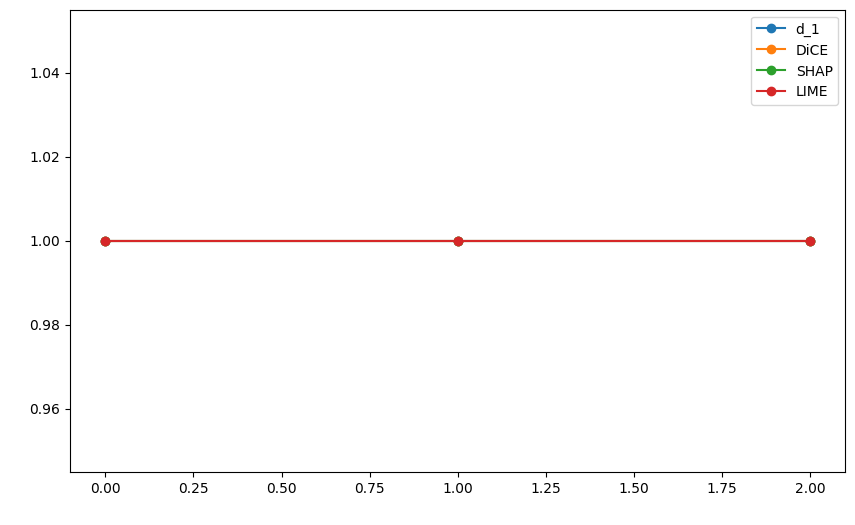

In [ ]:
rank_d1 = [1,0]
rank_dice = [1,0]
rank_shap = [0,1]
rank_lime = [1,0]

def mask_features(x, ranks, num_features):
    x_masked = x.copy()
    for i in range(num_features):
        x_masked[0, ranks[i]] = 0
    return x_masked


def calculate_comprehensiveness(model, x, ranks):
    original_proba = model.predict_proba(x)[0, 0]
    total_difference = 0
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x, ranks, l)
        masked_proba = model.predict_proba(x_masked)[0, 0]
        total_difference += (original_proba - masked_proba)
    return total_difference / (len(x_masked) + 1)

methods = {
    "d_1": rank_d1,
    "DiCE": rank_dice,
    "SHAP": rank_shap,
    "LIME": rank_lime
}

x_instance = x_test_final[0:1]  # the instance we want to explain
proba_results = {}
comprehensiveness_values = {}

for method, ranks in methods.items():
    proba_results[method] = []
    for l in range(len(ranks) + 1):
        x_masked = mask_features(x_instance, ranks, l)
        proba = model.predict_proba(x_masked)[0, 0]
        proba_results[method].append(proba)

    comprehensiveness = calculate_comprehensiveness(model, x_instance, ranks)
    print(f"Comprehensiveness for {method}: {comprehensiveness:.4f}")
    comprehensiveness_values[method] = comprehensiveness


plt.figure(figsize=(10, 6))

for method, probas in proba_results.items():
    plt.plot(range(len(probas)), probas, label=f"{method}", marker='o')

plt.xlabel(" ")
plt.ylabel(" ")
plt.legend()
plt.grid(False)
plt.show()

